<a href="https://colab.research.google.com/github/nv-hiep/Autoencoders/blob/main/Convolutional_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Reshape, Input
from keras.optimizers import SGD
from keras.layers import Conv2D, MaxPool2D, Conv2DTranspose, Dropout, ActivityRegularization
from keras.layers import LSTM, RepeatVector, TimeDistributed, GaussianNoise

In [ ]:
def plot_image(image):
    plt.imshow(image, cmap='binary')
    # plt.axis('off')

# Data

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
X_train_full = X_train_full / 255.
X_test       = X_test / 255.

In [ ]:
print('X_train_full.shape: ', X_train_full.shape)
print('y_train_full.shape: ', y_train_full.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

X_train_full.shape:  (60000, 28, 28)
y_train_full.shape:  (60000,)
X_test.shape:  (10000, 28, 28)
y_test.shape:  (10000,)


In [ ]:
train_size = 50_000

In [ ]:
X_train = X_train_full[:train_size]
X_valid = X_train_full[train_size:]

y_train = y_train_full[:train_size]
y_valid = y_train_full[train_size:]

print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_valid.shape: ', X_valid.shape)
print('y_valid.shape: ', y_valid.shape)

X_train.shape:  (50000, 28, 28)
y_train.shape:  (50000,)
X_valid.shape:  (10000, 28, 28)
y_valid.shape:  (10000,)


In [ ]:
def show_reconstructions(model, images=X_test, n_images=5):
  '''
  First row: real images
  Second row: reconstructed images
  '''
  reconstructions = model.predict(images[:n_images])

  plt.figure(figsize=(n_images * 1.5, 3))
  for img_id in range(n_images):
    plt.subplot(2, n_images, 1 + img_id)
    plot_image(images[img_id])
    plt.subplot(2, n_images, 1 + n_images + img_id)
    plot_image(reconstructions[img_id])
  plt.show()

# Convolutional Autoencoders

If you are dealing with images, then the autoencoders we have seen so far will not work well (unless the images are very small): Convolutional neural networks are far better suited than dense networks to work with images. So if you want to build an autoencoder for images (e.g., for unsupervised pretraining or dimensionality reduction), you will need to build a convolutional autoencoder.

The encoder is a regular CNN composed of convolutional layers and pooling layers. It typically reduces the spatial dimensionality of the inputs (i.e., height and width) while increasing the depth (i.e., the number of feature maps). The decoder must do the reverse (upscale the image and reduce its depth back to the original dimensions), and for this you can use transpose convolutional layers (alternatively, you could combine upsampling layers with convolutional layers).

Here is a simple convolutional autoencoder for Fashion MNIST:

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

conv_encoder = Sequential()
conv_encoder.add( Reshape([28,28,1], input_shape=[28,28] ) )
conv_encoder.add( Conv2D(16, kernel_size=3, padding='same', activation='selu') )
conv_encoder.add( MaxPool2D(pool_size=2) )
conv_encoder.add( Conv2D(32, kernel_size=3, padding='same', activation='selu') )
conv_encoder.add( MaxPool2D(pool_size=2) )
conv_encoder.add( Conv2D(64, kernel_size=3, padding='same', activation='selu') )
conv_encoder.add( MaxPool2D(pool_size=2) )
# 28x28 -> 26x26 -> 13x13 -> 11x11 -> 5x5 -> 3x3
# Output shape: 3,3,64

conv_decoder = Sequential()
conv_decoder.add( Conv2DTranspose(32, kernel_size=3, strides=2, padding='valid', activation='selu', input_shape=[3,3,64]) )
conv_decoder.add( Conv2DTranspose(16, kernel_size=3, strides=2, padding='same', activation='selu') )
conv_decoder.add( Conv2DTranspose(1, kernel_size=3, strides=2, padding='same', activation='sigmoid') )
conv_decoder.add( Reshape([28,28]) )

conv_autoencoder = Sequential([conv_encoder, conv_decoder])

conv_autoencoder.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=1.0), metrics=['binary_accuracy'])

In [ ]:
history = conv_autoencoder.fit(X_train, X_train, epochs=5, validation_data=(X_valid, X_valid))

Epoch 1/5
1563/1563 [==============================] - 87s 5ms/step - loss: 0.3420 - binary_accuracy: 0.5035 - val_loss: 0.2806 - val_binary_accuracy: 0.5060
Epoch 2/5
1563/1563 [==============================] - 7s 5ms/step - loss: 0.2780 - binary_accuracy: 0.5094 - val_loss: 0.2753 - val_binary_accuracy: 0.5067
Epoch 3/5
1563/1563 [==============================] - 7s 4ms/step - loss: 0.2719 - binary_accuracy: 0.5100 - val_loss: 0.2710 - val_binary_accuracy: 0.5068
Epoch 4/5
1563/1563 [==============================] - 7s 5ms/step - loss: 0.2685 - binary_accuracy: 0.5106 - val_loss: 0.2712 - val_binary_accuracy: 0.5065
Epoch 5/5
1563/1563 [==============================] - 7s 5ms/step - loss: 0.2672 - binary_accuracy: 0.5096 - val_loss: 0.2700 - val_binary_accuracy: 0.5070


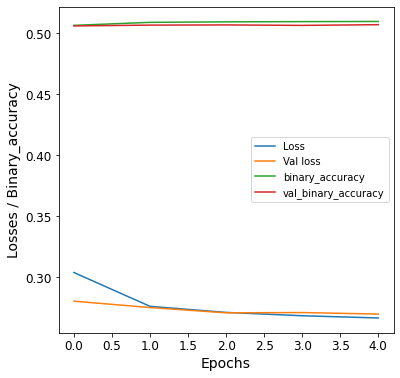

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val loss')

plt.plot(history.history['binary_accuracy'], label='binary_accuracy')
plt.plot(history.history['val_binary_accuracy'], label='val_binary_accuracy')

plt.xlabel('Epochs')
plt.ylabel('Losses / Binary_accuracy')

plt.legend()
plt.show()

In [ ]:
# Convolutional Encoder
conv_encoder.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_7 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 3, 3, 64)        

In [ ]:
# Convolutional Decoder
conv_decoder.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose_6 (Conv2DTr (None, 7, 7, 32)          18464     
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 14, 14, 16)        4624      
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 28, 28, 1)         145       
_________________________________________________________________
reshape_8 (Reshape)          (None, 28, 28)            0         
Total params: 23,233
Trainable params: 23,233
Non-trainable params: 0
_________________________________________________________________


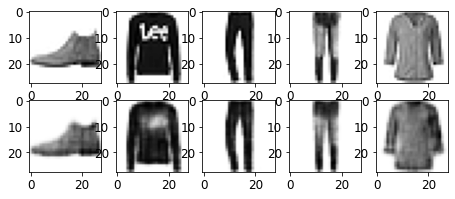

In [ ]:
# Plot the reconstructed images
show_reconstructions(conv_autoencoder, images=X_test)
plt.show()